In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import os
os.chdir('../methods')
import lsci, supr, conf, uqno
os.chdir('../gpsims')

In [3]:
def risk(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [4]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = data[(lag + horizon):][:,None]
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 1)
    return x_t.copy(), y_t.copy()

def torch2jax(x):
    return jnp.array(x.numpy())

In [5]:
class ANO_layer(nnx.Module):
    def __init__(self, width, rngs: nnx.Rngs):
        self.linear = nnx.Linear(width, width, rngs=rngs)
        # self.bn = nnx.BatchNorm(dmid, rngs=rngs)
        # self.dropout = nnx.Dropout(0.2, rngs=rngs)
        self.linear_out = nnx.Linear(width, width, rngs=rngs)
        
    def __call__(self, x):
        # channel mix
        h = self.linear(x)

        # spatial mix
        g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

        # sum
        x = h + g
        x = nnx.relu(x)

        return self.linear_out(x)

class encode_layer(nnx.Module):
    def __init__(self, in_dim, out_dim, rngs):
        self.linear = nnx.Linear(in_dim, out_dim, rngs=rngs)

    def __call__(self, x):
        return self.linear(x)

class DeepANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)

    def __call__(self, x):
        x = self.encode_layer(x)
        x = self.ano1(x)
        x = self.ano2(x)
        x = self.ano3(x)
        x = self.decode_layer(x)
        return x

In [6]:
class ProbANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.mu_ano = DeepANO(in_dim, width, out_dim, rngs)
        self.sd_ano = DeepANO(in_dim, width, out_dim, rngs)

    def __call__(self, x):
        mu = self.mu_ano(x)
        log_sd = self.sd_ano(x)
        return mu, jnp.exp(log_sd)

In [7]:
class DropANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, drop_prob, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)
        self.dropout = nnx.Dropout(drop_prob, rngs=rngs)

    def __call__(self, x):
        x = self.encode_layer(x)
        x = self.ano1(x)
        x = self.dropout(x)
        x = self.ano2(x)
        x = self.dropout(x)
        x = self.ano3(x)
        x = self.decode_layer(x)
        return x

In [8]:
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return jnp.mean((y_pred - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss

def quant_step(model, optimizer, x, y):
    def loss_fn(model):
        quant = 1 - 0.1
        y_pred = model(x)
        y_abs = jnp.abs(y)
        resid = y_abs - y_pred
        loss = jnp.max(jnp.concat([quant * resid, -(1-quant) * resid], axis = 3), axis = 3)
        return jnp.mean(loss)
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss

def prob_step(model, optimizer, x, y):
    def loss_fn(model):
        mu, sd = model(x)
        var = sd**2
        nll = jnp.mean((mu - y)**2 / (2*var) + 0.5 * jnp.log(var))
        return nll

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss

train_step = nnx.jit(train_step)
quant_step = nnx.jit(quant_step)
prob_step = nnx.jit(prob_step)

In [9]:
def gp1d(n, p, rng = 1, mu = 0, sigma = 0.1, rho = 0.2):
    
    def conv(x, k):
        return jnp.convolve(x, k, mode = 'valid')
    conv = jit(vmap(conv, (0, None)))
    kernel = jnp.ones(3)/3
    
    p = p + 2
    key = random.PRNGKey(rng)
    t = jnp.linspace(0, 1, p)

    k = (t[None,:] - t[:,None])**2
    k = np.identity(p) + jnp.exp(-k/rho**2)
    k_half = jnp.linalg.cholesky(k)
    
    x = sigma * random.normal(key, (n, p))
    x = (k_half @ x.T).T
    x = mu + conv(x, kernel)
    return x

In [10]:
n, p = 501, 50
t = jnp.linspace(0, 1, p)
s = jnp.linspace(-2*math.pi, 2*math.pi, n)

amp = jnp.sin(s)
sd = jnp.sin(s)

sigma = 0.25 * (1.15 + sd)[:,None]
mu = jnp.sin(2 * math.pi * t)
mu = 10 + amp[:,None] * mu[None,:]

In [11]:
xtrain = gp1d(n, p, rng = 0, mu = mu, sigma = sigma)
xtrain, ytrain = split_data(xtrain, 1, 1)
xtrain = xtrain[:,:,:,None]
ytrain = ytrain[:,:,:,None]

xval = gp1d(n, p, rng = 1, mu = mu, sigma = sigma)
xval, yval = split_data(xval, 1, 1)
xval = xval[:,:,:,None]
yval = yval[:,:,:,None]

xtest = gp1d(n, p, rng = 2, mu = mu, sigma = sigma)
xtest, ytest = split_data(xtest, 1, 1)
xtest = xtest[:,:,:,None]
ytest = ytest[:,:,:,None]

In [12]:
def conv(x, k):
    return jnp.convolve(x, k, mode = 'valid')
conv = jit(vmap(conv, (0, None)))
kernel = jnp.ones(5)/5

rng0 = 100
key1 = random.PRNGKey(rng0 + 1)
key2 = random.PRNGKey(rng0 + 2)
key3 = random.PRNGKey(rng0 + 3)

t = jnp.linspace(0, 1, 108)
s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.sin(s)

f = jnp.sin(2 * math.pi * t)
f = 10 + amp[:,None] * f[None,:]

xtrain = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key1, f.shape)
xtrain = conv(conv(xtrain.squeeze(), kernel), kernel)
xtrain, ytrain = split_data(xtrain, 1, 1)
xtrain = xtrain[:,:,:,None]
ytrain = ytrain[:,:,:,None]

xval = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key2, f.shape)
xval = conv(conv(xval.squeeze(), kernel), kernel)

xval, yval = split_data(xval, 1, 1)
xval = xval[:,:,:,None]
yval = yval[:,:,:,None]

xtest = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key3, f.shape)
xtest = conv(conv(xtest.squeeze(), kernel), kernel)

xtest, ytest = split_data(xtest, 1, 1)
xtest = xtest[:,:,:,None]
ytest = ytest[:,:,:,None]

sigma = 0.25 * (1.15 + sd)

In [13]:
# def conv(x, k):
#     return jnp.convolve(x, k, mode = 'same')
# conv = jit(vmap(conv, (0, None)))
# kernel = jnp.ones(5)/5

# ### train
# rng0 = 1
# key1 = random.PRNGKey(rng0 + 1)

# n, p = 1000, 50
# beta = random.normal(key1, (5,))
# bias = 1

# rng0 = 2
# rng = random.PRNGKey(rng0)
# key1, key2, key3 = random.split(rng, 3)

# xtrain = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
# sigma = jnp.std(xtrain, axis = 1)
# sigma = sigma - jnp.mean(sigma) + 1
# epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

# ytrain = bias + conv(xtrain, beta) + epsilon
# xtrain = xtrain[:,None,:,None]
# ytrain = ytrain[:,None,:,None]

# ### valid
# rng0 += 1
# rng = random.PRNGKey(rng0)
# key1, key2, key3 = random.split(rng, 3)

# xval = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
# sigma = jnp.std(xval, axis = 1)
# sigma = sigma - jnp.mean(sigma) + 1
# epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

# yval = bias + conv(xval, beta) + epsilon
# xval = xval[:,None,:,None]
# yval = yval[:,None,:,None]


# ### test
# rng0 += 1
# rng = random.PRNGKey(rng0)
# key1, key2, key3 = random.split(rng, 3)

# xtest = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
# sigma = jnp.std(xtest, axis = 1)
# sigma = sigma - jnp.mean(sigma) + 1
# epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

# ytest = bias + conv(xtest, beta) + epsilon
# xtest = xtest[:,None,:,None]
# ytest = ytest[:,None,:,None]

In [14]:
train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [15]:
epochs = 100
trace = []
lag, lead = 1, 1

base_model = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(base_model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(base_model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
drop_model = DropANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(drop_model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(drop_model, optim, xt, yt)
        trace.append(loss)

In [ ]:
quant_model = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(quant_model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = quant_step(quant_model, optim, xt, yt)
        trace.append(loss)

In [ ]:
prob_model = ProbANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(prob_model, optax.adam(1e-4))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = prob_step(prob_model, optim, xt, yt)
        trace.append(loss)

In [ ]:
yval_hat = base_model(xval)
ytest_hat = base_model(xtest)

yval_quant = quant_model(xval)
ytest_quant = quant_model(xtest)

yval_mu, yval_sd = prob_model(xval)
ytest_mu, ytest_sd = prob_model(xtest)

In [ ]:
yval = yval.squeeze()
ytest = ytest.squeeze()

yval_hat = yval_hat.squeeze()
ytest_hat = ytest_hat.squeeze()
yval_quant = yval_quant.squeeze()
ytest_quant = ytest_quant.squeeze()
yval_mu = yval_mu.squeeze()
yval_sd = yval_sd.squeeze()
ytest_mu = ytest_mu.squeeze()
ytest_sd = ytest_sd.squeeze()

In [ ]:
# yval = yval.reshape(yval.shape[0], -1)
# mu_val = yval_hat.reshape(mu_val.shape[0], -1)
# sd_val = sd_val.reshape(sd_val.shape[0], -1)

In [ ]:
def pdon(prob_model, xval, xtest, yval, alpha):
    
    nval = xval.shape[0]
    ntest = xtest.shape[0]
    
    mu_val, sd_val = prob_model(xval)
    mu_test, sd_test = prob_model(xtest)
    
    yval = yval.reshape(nval, -1)
    mu_val = mu_val.reshape(nval, -1)
    sd_val = sd_val.reshape(nval, -1)
    mu_test = mu_test.reshape(ntest, -1)
    sd_test = sd_test.reshape(ntest, -1)
    
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/(nval)
    
    score = jnp.abs(yval - mu_val)/sd_val
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -sd_test * q[None,]
    upper = sd_test * q[None,]
    return lower, upper

In [ ]:
def qdon(quant_model, xval, xtest, yval, alpha):
    
    nval = xval.shape[0]
    ntest = xtest.shape[0]
    
    yval = yval.reshape(nval, -1)
    
    quant_val = quant_model(xval).reshape(nval, -1)
    quant_test = quant_model(xtest).reshape(nval, -1)
    
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/(nval)
    
    lower = -quant_val - yval
    upper = yval - quant_val
    score = jnp.max(jnp.stack([lower, upper], axis = 2), axis=2)
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -quant_test - q[None,]
    upper = quant_test + q[None,]
    return lower, upper

In [ ]:
# pdon_lower, pdon_upper = pdon(prob_model, xval, xtest, yval, alpha)

In [ ]:
def gaussian_score(res, mu, sd):
    nll = jnp.mean((mu - res)**2 / (2*sd**2) + 0.5 * jnp.log(sd**2))
    return jnp.exp(-nll)
gaussian_score = vmap(gaussian_score, (0, None, None))

def gaus_band(residuals, pca_state, alpha):
    res_proj = pcax.transform(pca_state, residuals)
    mu = jnp.mean(res_proj, axis = 0)
    sd = jnp.std(res_proj, axis = 0)
    dval_conf = gaussian_score(res_proj, mu, sd)
    qval_conf = jnp.quantile(dval_conf, alpha)
    conf_ens = pcax.recover(pca_state, res_proj[dval_conf > qval_conf])
    conf_lower = jnp.min(conf_ens, axis = 0)
    conf_upper = jnp.max(conf_ens, axis = 0)
    return conf_lower, conf_upper

In [ ]:
# plt.plot(pdon_lower[2])
# plt.plot(pdon_upper[2])
# plt.plot(rtest2[2])

In [ ]:
# nproj = 90
# gamma1 = 0.2
# alpha = 0.1
# nval = xval.shape[0]
# alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

In [ ]:
# yval = yval.reshape(yval.shape[0], -1)
# yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
# # pca_state = lsci.phi_state(yval, yval_hat, nproj)

In [ ]:
# UQNO lambda estimate
# yval_quant = yval_quant.reshape(yval_quant.shape[0], -1)
# ytest_quant = ytest_quant.reshape(ytest_quant.shape[0], -1)

alpha = 0.1
delta = 0.1
# m = 32*64
m = 100
tau = 1.1 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval - yval_hat) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha)
lam_uqno

In [ ]:
# quant_scores = jnp.abs(yval - yval_hat) / yval_quant
# lam_uqno = estimate_lambda(quant_scores, 0.1, 0.01, 1.1)

In [90]:
nproj = npc = 100
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

drop_risk, drop_width = [], []
orcl_risk, orcl_width = [], []
conf_risk, conf_width = [], []
gaus_risk, gaus_width = [], []
supr_risk, supr_width = [], []
uqn1_risk, uqn1_width = [], []
pdon_risk, pdon_width = [], []
qdon_risk, qdon_width = [], []
lsc1_risk, lsc1_width = [], []
lsc2_risk, lsc2_width = [], []

# pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()
rtest2 = (ytest - ytest_mu).squeeze()

# xval = xval.squeeze()
# rval = rval.squeeze()
# xtest = xtest.squeeze()
state = lsci.lsci_state(xval, rval, npc)
pca_state = state[-1]

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
gaus_lower, gaus_upper = gaus_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)
pdon_lower, pdon_upper = pdon(prob_model, xval, xtest, yval, alpha)
qdon_lower, qdon_upper = qdon(quant_model, xval, xtest, yval - yval_hat, alpha)

for i in trange(0, ytest.shape[0]):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest.squeeze()[i], state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma2)
    lsc2_risk.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # Oracle
    orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
    orcl_upper = jnp.abs(rtest[i]) + 1e-4
    orcl_risk.append(risk(orcl_lower, orcl_upper, rtest[i]))
    orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
    # CONF 
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # GAUSS 
    gaus_risk.append(risk(gaus_lower, gaus_upper, rtest[i]))
    gaus_width.append(jnp.median(gaus_upper - gaus_lower))
    
    # SUPR
    supr_risk.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_risk.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))
    
    # PDON
    pdon_risk.append(risk(pdon_lower[i], pdon_upper[i], rtest2[i]))
    pdon_width.append(jnp.median(pdon_upper[i] - pdon_lower[i]))
    
    # PDON
    qdon_risk.append(risk(qdon_lower[i], qdon_upper[i], rtest[i]))
    qdon_width.append(jnp.median(qdon_upper[i] - qdon_lower[i]))
    
#     # DROPOUT
#     drop_model.train()
#     drop_set = jnp.stack([drop_model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
#     drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
#     drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
#     drop_model.eval()
    
#     drop_risk.append(risk(drop_lower, drop_upper, rtest[i]))
#     drop_width.append(jnp.median(drop_upper - drop_lower))


orcl_risk, orcl_width = np.array(orcl_risk), np.array(orcl_width)
drop_risk, drop_width = np.array(drop_risk), np.array(drop_width)
conf_risk, conf_width = np.array(conf_risk), np.array(conf_width)
gaus_risk, gaus_width = np.array(gaus_risk), np.array(gaus_width)
supr_risk, supr_width = np.array(supr_risk), np.array(supr_width)
uqn1_risk, uqn1_width = np.array(uqn1_risk), np.array(uqn1_width)
lsc1_risk, lsc1_width = np.array(lsc1_risk), np.array(lsc1_width)
lsc2_risk, lsc2_width = np.array(lsc2_risk), np.array(lsc2_width)
pdon_risk, pdon_width = np.array(pdon_risk), np.array(pdon_width)
qdon_risk, qdon_width = np.array(qdon_risk), np.array(qdon_width)

  0%|          | 0/500 [00:00<?, ?it/s]

ValueError: zero-size array to reduction operation min which has no identity

In [98]:
alpha = 0.1
gamma = 0.1
nsamp = 2000

In [107]:
lsci.lsci(xtest[0].squeeze(), state, alpha, nsamp = nsamp, gamma = gamma, rng = random.PRNGKey(0))

Array([], shape=(0, 100), dtype=float32)

In [123]:
import os
os.chdir('../methods')
import lsci, supr, conf, uqno
os.chdir('../gpsims')

In [124]:
xtest[0].squeeze().shape

(100,)

In [128]:
lsci.lsci(xtest[0].squeeze(), state, alpha, nsamp = nsamp, gamma = gamma, rng = random.PRNGKey(0))

Array([], shape=(0, 100), dtype=float32)

In [121]:
import inspect
print(inspect.getsource(lsci.lsci))

def lsci(xtest, state, alpha, nsamp, gamma = 0.1, rng = random.PRNGKey(0)):
    
    print('blah')
    
    rval2, xval2, pca_state = state
    
    nval = rval2.shape[0]
    npc = rval2.shape[1]
    xtest2 = pcax.transform(pca_state, xtest[None,])
    
    print(xtest2.shape)
    
    alpha = 1 - jnp.ceil((gamma*nval + 1) * (1 - alpha))/(gamma*nval)

    weight = local_weights(xval2, xtest2, gamma).squeeze()
    unif = random.uniform(rng, (nsamp, npc))
    quants = jnp.linspace(jnp.min(rval2) - 0.1, jnp.max(rval2) + 0.1, 100)
    
    print(quants)

    local_cdfs = lcdf(rval2, quants, weight)
    local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    local_phi = quants[local_quants].T

    dval = jnp.mean(local_tukey_self(rval2, rval2, weight), axis = 0)
    qval = jnp.quantile(dval, alpha)
    dphi = jnp.mean(local_tukey_self(rval2, local_phi, weight), axis = 0)

    local_ens = pcax.recover(pca_state, local_phi)
#     local_ens = local_ens[dphi > qval]
   

In [26]:
# lsc1_risk = random.normal(rng, (500,))
# lsc2_risk = random.normal(rng, (500,))
# lsc1_width = random.normal(rng, (500,))
# lsc2_width = random.normal(rng, (500,))

# drop_risk = random.normal(rng, (50,))
# drop_width = random.normal(rng, (50,))

In [27]:
noise_sd.shape

NameError: name 'noise_sd' is not defined

In [251]:
# noise_sd = np.std(rtest[0:100], axis = 1)
# noise_sd = 0.25 * (1.15 + sd)
# noise_sd = noise_sd[1:]
noise_sd = sigma[1:]
gamma = 0.99

risk_control = np.mean(orcl_risk >= gamma), \
               np.mean(drop_risk >= gamma), \
               np.mean(conf_risk >= gamma), \
               np.mean(gaus_risk >= gamma), \
               np.mean(supr_risk >= gamma), \
               np.mean(uqn1_risk >= gamma), \
               np.mean(pdon_risk >= gamma), \
               np.mean(qdon_risk >= gamma), \
               np.mean(lsc1_risk >= gamma), \
               np.mean(lsc2_risk >= gamma)

width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = -0, \
           np.corrcoef([noise_sd, drop_risk])[0,1], \
           np.corrcoef([noise_sd, conf_risk])[0,1], \
           np.corrcoef([noise_sd, gaus_risk])[0,1], \
           np.corrcoef([noise_sd, supr_risk])[0,1], \
           np.corrcoef([noise_sd, uqn1_risk])[0,1], \
           np.corrcoef([noise_sd, pdon_risk])[0,1], \
           np.corrcoef([noise_sd, qdon_risk])[0,1], \
           np.corrcoef([noise_sd, lsc1_risk])[0,1], \
           np.corrcoef([noise_sd, lsc2_risk])[0,1]

width_cor = 1, \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            0, \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, pdon_width])[0,1], \
            np.corrcoef([noise_sd, qdon_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

/Users/trevorharris/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/trevorharris/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [252]:
np.set_printoptions(suppress=True)
print(np.round(metrics, 3))

[[ 1.     0.     0.224  1.   ]
 [ 0.       nan  0.536  0.062]
 [ 0.816 -0.461  1.247  0.   ]
 [ 0.788 -0.493  1.204  0.   ]
 [ 0.896 -0.359  1.411  0.   ]
 [ 0.96  -0.226  1.57   0.027]
 [ 0.508 -0.378 11.062  0.089]
 [ 0.394 -0.067  1.062  0.434]
 [ 0.912 -0.063  0.901  0.992]
 [ 0.872 -0.098  0.872  0.991]]


In [253]:
# noise_sd = np.std(rtest[0:100], axis = 1)
noise_sd = 0.25 * (1.15 + sd)
noise_sd = noise_sd[1:]
gamma = 0.99

risk_control = np.mean(orcl_risk >= gamma), \
               np.mean(drop_risk >= gamma), \
               np.mean(conf_risk >= gamma), \
               np.mean(gaus_risk >= gamma), \
               np.mean(supr_risk >= gamma), \
               np.mean(uqn1_risk >= gamma), \
               np.mean(pdon_risk >= gamma), \
               np.mean(qdon_risk >= gamma), \
               np.mean(lsc1_risk >= gamma), \
               np.mean(lsc2_risk >= gamma)

width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = -0, \
           np.corrcoef([noise_sd, drop_risk])[0,1], \
           np.corrcoef([noise_sd, conf_risk])[0,1], \
           np.corrcoef([noise_sd, gaus_risk])[0,1], \
           np.corrcoef([noise_sd, supr_risk])[0,1], \
           np.corrcoef([noise_sd, uqn1_risk])[0,1], \
           np.corrcoef([noise_sd, pdon_risk])[0,1], \
           np.corrcoef([noise_sd, qdon_risk])[0,1], \
           np.corrcoef([noise_sd, lsc1_risk])[0,1], \
           np.corrcoef([noise_sd, lsc2_risk])[0,1]

width_cor = 1, \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            0, \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, pdon_width])[0,1], \
            np.corrcoef([noise_sd, qdon_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [254]:
np.set_printoptions(suppress=True)
print(np.round(metrics, 3))

[[ 1.     0.     0.224  1.   ]
 [ 0.       nan  0.536  0.062]
 [ 0.816 -0.461  1.247  0.   ]
 [ 0.788 -0.493  1.204  0.   ]
 [ 0.896 -0.359  1.411  0.   ]
 [ 0.96  -0.226  1.57   0.027]
 [ 0.508 -0.378 11.062  0.089]
 [ 0.394 -0.067  1.062  0.434]
 [ 0.912 -0.063  0.901  0.992]
 [ 0.872 -0.098  0.872  0.991]]


In [255]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 0.224 & 1.000 \\
0.000 & 0.000 & 0.536 & 0.062 \\
0.816 & -0.461 & 1.247 & 0.000 \\
0.788 & -0.493 & 1.204 & 0.000 \\
0.896 & -0.359 & 1.411 & 0.000 \\
0.960 & -0.226 & 1.570 & 0.027 \\
0.508 & -0.378 & 11.062 & 0.089 \\
0.394 & -0.067 & 1.062 & 0.434 \\
0.912 & -0.063 & 0.901 & 0.992 \\
0.872 & -0.098 & 0.872 & 0.991 \\


In [263]:
import timeit

tic = timeit.default_timer()
lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma1, 2000)
toc = timeit.default_timer()
# end = time.time()
print(toc - tic)

0.6438459171913564


In [351]:
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random

import pcax

def warp01(cdf):
    _min = jnp.min(cdf, axis = 0)[None,]
    _max = jnp.max(cdf, axis = 0)[None,]
    return (cdf - _min) / (_max - _min)

def local_weights(yval, ytest, frac = 0.1):
    dmat = jnp.max(jnp.abs(yval - ytest), axis = 1)
    quant = jnp.quantile(dmat, frac, axis = 0)
    indx = dmat < quant
    inner_max = jnp.max(dmat * indx)
    dmat = inner_max - dmat
    w = dmat * indx
    return w / jnp.sum(w, axis = 0)[None,]
local_weights = jit(vmap(local_weights, (None, 0, None)))

def local_cdf(rval, q, weight):
    lcdf = jnp.sum(weight * (rval < q))
    return lcdf
local_cdf = jit(local_cdf)
local_cdf = jit(vmap(local_cdf, (None, None, 0)))

def local_quantile(rval, p, weight):
    rval_sort = jnp.sort(rval, axis = 0)
    lcdf = jnp.sum(weight[None,:] * (rval[None,:] < rval_sort[:,None]), axis = 1)
    lcdf = warp01(lcdf)
    ind = jnp.argmax(1.0*(lcdf >= p))
    return rval_sort[ind]
local_quantile = jit(local_quantile)
local_quantile_vmap = jit(vmap(local_quantile, (1, None, None)))
local_quantile_proj = vmap(local_quantile_vmap, (None, None, 0))

def local_tukey(rval, q, weight):
    lcdf_l = jnp.sum(weight * (rval < q))
    lcdf_r = jnp.sum(weight * (rval > q))
    return 2 * jnp.min(jnp.array([lcdf_l, lcdf_r]))
local_tukey = jit(local_tukey)
local_tukey_vmap = vmap(local_tukey, (1, 1, None))
local_tukey_self = vmap(local_tukey, (None, 0, None))
local_tukey_self = jit(vmap(local_tukey_self, (1, 1, None)))

def random_phi(rng, rval, weight):
    phi = local_quantile(rval, jax.random.uniform(rng), weight)
    return phi
random_phi = jit(vmap(random_phi, (None, 1, None)))

def phi_ensemble(rng, rval, weight):
    rngs = random.split(rng, rval.shape[1])
    return random_phi(rngs, rval, weight)
phi_ensemble = vmap(phi_ensemble, (0, None, None))

def lsci_ensemble(rval, weight, pca_state, alpha, nsamp, rng = random.PRNGKey(0)):
    rval_proj = pcax.transform(pca_state, rval)
    rngs = random.split(rng, nsamp)
    phi_t = phi_ensemble(rngs, rval_proj, weight)
    ens_t = pcax.recover(pca_state, phi_t)
    
    dval = jnp.mean(local_tukey_self(rval_proj, rval_proj, weight), axis = 0)
    qval = jnp.quantile(dval, alpha)
    dphi = jnp.mean(local_tukey_self(rval_proj, phi_t, weight), axis = 0)
    return ens_t[dphi > qval]

def lsci_band(rval, weight, pca_state, alpha, nsamp, rng = random.PRNGKey(0)):
    lsci_conf = lsci_ensemble(rval, weight, pca_state, alpha, nsamp, rng)
    lsci_lower = jnp.min(lsci_conf, axis = 0)
    lsci_upper = jnp.max(lsci_conf, axis = 0)
    return lsci_lower, lsci_upper

def phi_state(yval, yval_hat, nproj):
    yval = yval.reshape(yval.shape[0], -1)
    yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
    rval = yval - yval_hat
    return pcax.fit(rval, n_components=nproj)

def lsci(rval, xval, xtest, pca_state, alpha, gamma, nsamp):
    xval = xval.squeeze()
    rval = rval.squeeze()
    xtest = xtest.squeeze()[None,]
    lweight = local_weights(xval, xtest, gamma)[0]
    return lsci_band(rval, lweight, pca_state, alpha, nsamp)

In [352]:
# lweight = local_weights(xval, xtest, gamma)[0]
# lweight.shape

In [353]:
# def lsci_ensemble(rval, weight, pca_state, alpha, nsamp, rng = random.PRNGKey(0)):
#     rval_proj = pcax.transform(pca_state, rval)
#     rngs = random.split(rng, nsamp)
#     phi_t = phi_ensemble(rngs, rval_proj, weight)
#     ens_t = pcax.recover(pca_state, phi_t)
    
#     dval = jnp.mean(local_tukey_self(rval_proj, rval_proj, weight), axis = 0)
#     qval = jnp.quantile(dval, alpha)
#     dphi = jnp.mean(local_tukey_self(rval_proj, phi_t, weight), axis = 0)
#     return ens_t, dphi, qval

# lsci_ensemble = jit(lsci_ensemble, static_argnums = 4)


# def lsci_band(rval, weight, pca_state, alpha, nsamp, rng = random.PRNGKey(0)):
#     lsci_conf, dphi, qval = lsci_ensemble(rval, weight, pca_state, alpha, nsamp, rng)
#     lsci_conf = lsci_conf[dphi > qval]
#     lsci_lower = jnp.min(lsci_conf, axis = 0)
#     lsci_upper = jnp.max(lsci_conf, axis = 0)
#     return lsci_lower, lsci_upper

# # lsci_band = jit(lsci_band, static_argnums = 4)

In [ ]:
def local_quantile(rval, p, weight):
    rval_sort = jnp.sort(rval, axis = 0)
    lcdf = jnp.sum(weight[None,:] * (rval[None,:] < rval_sort[:,None]), axis = 1)
    lcdf = warp01(lcdf)
    ind = jnp.argmax(1.0*(lcdf >= p))
    return rval_sort[ind]
local_quantile = jit(local_quantile)
local_quantile_vmap = jit(vmap(local_quantile, (1, None, None)))

In [561]:
nsamp = 2000
npc = 100
unif = random.uniform(rng, (nsamp, npc))
quants = jnp.linspace(jnp.min(rval)-0.1, jnp.max(rval)+0.1, 200)
weight = jnp.ones(nval)/nval

In [562]:
def lcdf(rval, q, weight):
    return jnp.sum(weight[:,None] * (rval < q), axis = 0)
lcdf = jit(vmap(lcdf, (None, 0, None)))

In [563]:
local_cdfs = lcdf(rval, quants, weight)
local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
local_phi = quants[local_quants]

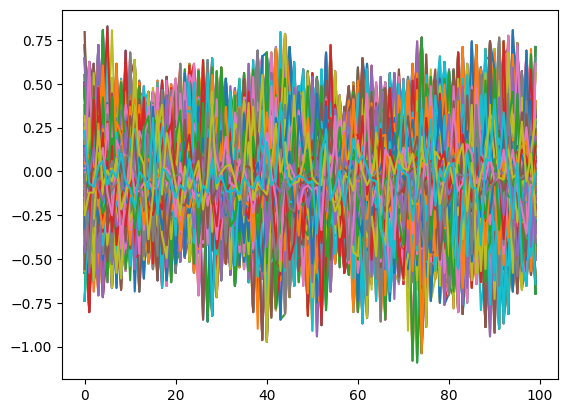

In [564]:
plt.plot(local_phi)
plt.show()

In [682]:
unif.shape, local_cdfs.shape, weight.shape

((2000, 90), (200, 100), (500,))

In [28]:
def lcdf(rval, q, weight):
    return jnp.sum(weight[:,None] * (rval < q), axis = 0)
lcdf = jit(vmap(lcdf, (None, 0, None)))

In [690]:
# pca_state = phi_state(yval, yval_hat, nproj)

In [694]:
nsamp = 2000
npc = 10

pca_state = phi_state(yval, yval_hat, npc)

xval = xval.squeeze()
rval = rval.squeeze()
xtest = xtest.squeeze()

rval2 = pcax.transform(pca_state, rval)
xval2 = pcax.transform(pca_state, xval)
xtest2 = pcax.transform(pca_state, xtest)

tic = timeit.default_timer()

weight = local_weights(xval2, xtest2[0:1], gamma).squeeze()

unif = random.uniform(rng, (nsamp, npc))
quants = jnp.linspace(jnp.min(rval2) - 0.1, jnp.max(rval2) + 0.1, 200)

local_cdfs = lcdf(rval2, quants, weight)
local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
local_phi = quants[local_quants].T

dval = jnp.mean(local_tukey_self(rval2, rval2, weight), axis = 0)
qval = jnp.quantile(dval, alpha)
dphi = jnp.mean(local_tukey_self(rval2, local_phi, weight), axis = 0)

local_ens = pcax.recover(pca_state, local_phi)
local_ens = local_ens[dphi > qval]

toc = timeit.default_timer()
print(toc-tic)

0.04349591722711921


In [696]:
nsamp = 2000
npc = 90

def lsci(xval, rval, xtest, pca_state):

    xval = xval.squeeze()
    rval = rval.squeeze()
    xtest = xtest.squeeze()

    rval2 = pcax.transform(pca_state, rval)
    xval2 = pcax.transform(pca_state, xval)
    xtest2 = pcax.transform(pca_state, xtest)[None,]

    weight = local_weights(xval2, xtest2, gamma).squeeze()

    unif = random.uniform(rng, (nsamp, npc))
    quants = jnp.linspace(jnp.min(rval2) - 0.1, jnp.max(rval2) + 0.1, 100)

    local_cdfs = lcdf(rval2, quants, weight)
    local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    local_phi = quants[local_quants].T

    dval = jnp.mean(local_tukey_self(rval2, rval2, weight), axis = 0)
    qval = jnp.quantile(dval, alpha)
    dphi = jnp.mean(local_tukey_self(rval2, local_phi, weight), axis = 0)

    local_ens = pcax.recover(pca_state, local_phi)
    local_ens = local_ens[dphi > qval]
    return local_ens

In [34]:
nsamp = 2000
npc = 90

def lsci_state(xval, rval, npc):
    xval = xval.squeeze()
    rval = rval.squeeze()
    pca_state = pcax.fit(rval, n_components=nproj)
    rval2 = pcax.transform(pca_state, rval)
    xval2 = pcax.transform(pca_state, xval)
    return [rval2, xval2, pca_state]

In [35]:
# rval2, xval2, pca_state = state

In [60]:
def lcdf(rval, q, weight):
    return jnp.sum(weight[:,None] * (rval < q), axis = 0)
lcdf = jit(vmap(lcdf, (None, 0, None)))

def local_weights(yval, ytest, frac = 0.1):
    dmat = jnp.max(jnp.abs(yval - ytest), axis = 1)
    quant = jnp.quantile(dmat, frac, axis = 0)
    indx = dmat < quant
    inner_max = jnp.max(dmat * indx)
    dmat = inner_max - dmat
    w = dmat * indx
    return w / jnp.sum(w, axis = 0)[None,]
local_weights = jit(vmap(local_weights, (None, 0, None)))

def local_tukey(rval, q, weight):
    lcdf_l = jnp.sum(weight * (rval < q))
    lcdf_r = jnp.sum(weight * (rval > q))
    return 2 * jnp.min(jnp.array([lcdf_l, lcdf_r]))
local_tukey = jit(local_tukey)
local_tukey_vmap = vmap(local_tukey, (1, 1, None))
local_tukey_self = vmap(local_tukey, (None, 0, None))
local_tukey_self = jit(vmap(local_tukey_self, (1, 1, None)))

def lsci_state(xval, rval, npc):
    xval = xval.squeeze()
    rval = rval.squeeze()
    pca_state = pcax.fit(rval, n_components=npc)
    rval2 = pcax.transform(pca_state, rval)
    xval2 = pcax.transform(pca_state, xval)
    return [rval2, xval2, pca_state]

def lsci(xtest, state, alpha, nsamp, gamma = 0.1):
    
    rval2, xval2, pca_state = state
    
    nval = rval2.shape[0]
    npc = rval2.shape[1]
    xtest2 = pcax.transform(pca_state, xtest)[None,]
    
    alpha = 1 - jnp.ceil((nval + 1) * (1 - alpha))/nval

    weight = local_weights(xval2, xtest2, gamma).squeeze()
    unif = random.uniform(rng, (nsamp, npc))
    quants = jnp.linspace(jnp.min(rval2) - 0.1, jnp.max(rval2) + 0.1, 100)

    local_cdfs = lcdf(rval2, quants, weight)
    local_quants = jnp.argmax(local_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    local_phi = quants[local_quants].T

    dval = jnp.mean(local_tukey_self(rval2, rval2, weight), axis = 0)
    qval = jnp.quantile(dval, alpha)
    dphi = jnp.mean(local_tukey_self(rval2, local_phi, weight), axis = 0)

    local_ens = pcax.recover(pca_state, local_phi)
    local_ens = local_ens[dphi > qval]
    return local_ens

def lsci_band(xtest, state, alpha, nsamp, gamma = 0.1):
    local_ens = lsci(xtest, state, alpha, nsamp, gamma = gamma)
    return jnp.min(local_ens, axis = 0), jnp.max(local_ens, axis = 0)

In [63]:
xtest = xtest.squeeze()
lsci(xtest[i], state, alpha, 2000)

Array([], shape=(0, 100), dtype=float32)

In [49]:
nsamp = 2000
npc = 10
alpha = 0.1

rval = (yval - yval_hat).squeeze()

xval = xval.squeeze()
rval = rval.squeeze()
xtest = xtest.squeeze()
state = lsci_state(xval, rval, npc)

In [58]:
import timeit
tic = timeit.default_timer()
local_ens = [lsci(xtest[i], state, alpha, 2000) for i in trange(500)]
toc = timeit.default_timer()
print(toc-tic)

  0%|          | 0/500 [00:00<?, ?it/s]

13.72455145791173


In [62]:
jnp.min(local_ens[0], axis = 0), jnp.max(local_ens[0], axis = 0)

(Array([-0.5107432 , -0.51738095, -0.50762284, -0.48895162, -0.45042717,
        -0.40118805, -0.40375212, -0.4195735 , -0.44333422, -0.47372442,
        -0.48794302, -0.5102575 , -0.48188567, -0.4626013 , -0.4197095 ,
        -0.3770352 , -0.37553626, -0.38748807, -0.46424818, -0.5363739 ,
        -0.57180524, -0.5817116 , -0.56414723, -0.58551073, -0.5732491 ,
        -0.544721  , -0.50995404, -0.47674525, -0.43290696, -0.4059421 ,
        -0.4125762 , -0.3981577 , -0.40046957, -0.42418566, -0.50852907,
        -0.5549524 , -0.5908788 , -0.5815368 , -0.5359805 , -0.5262567 ,
        -0.515357  , -0.54417557, -0.6025991 , -0.64095485, -0.6685328 ,
        -0.633957  , -0.5734055 , -0.5098614 , -0.4816942 , -0.462426  ,
        -0.44363785, -0.4150152 , -0.4251026 , -0.4102203 , -0.3937384 ,
        -0.39110786, -0.40372977, -0.4170171 , -0.43337703, -0.48029602,
        -0.5392385 , -0.5696206 , -0.5916241 , -0.5730976 , -0.53212184,
        -0.51387376, -0.51475245, -0.57174087, -0.6

In [706]:
tic = timeit.default_timer()

nsamp = 2000
npc = 10
pca_state = phi_state(yval, yval_hat, npc)

local_ens = lsci(xval, rval, xtest[0], pca_state)
toc = timeit.default_timer()
print(toc-tic)

0.07595362514257431


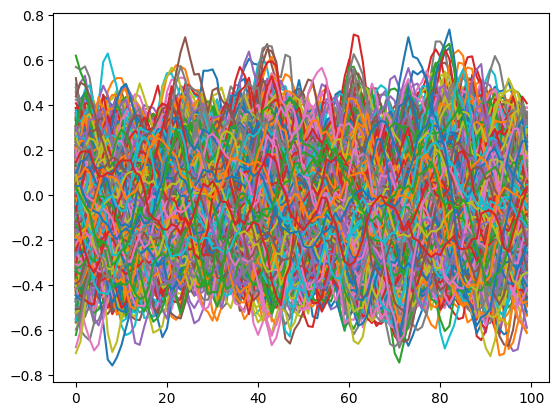

In [636]:
plt.plot(local_ens.T)
plt.show()

In [363]:

def random_phi(rng, rval, weight):
    phi = local_quantile(rval, jax.random.uniform(rng), weight)
    return phi
random_phi = jit(vmap(random_phi, (None, 1, None)))

def phi_ensemble(rng, rval, weight):
#     rngs = random.split(rng, rval.shape[1])
    return random_phi(rng, rval, weight)
phi_ensemble = jit(phi_ensemble)
phi_ensemble = jit(vmap(phi_ensemble, (0, None, None)))


def lsci_ensemble(rval, weight, pca_state, alpha, nsamp, rng = random.PRNGKey(0)):
#     rval_proj = pcax.transform(pca_state, rval)
    tic = timeit.default_timer()
    rngs = random.split(rng, nsamp)
    phi_t = phi_ensemble(rngs, rval, weight)
    print(phi_t.shape)
#     ens_t = pcax.recover(pca_state, phi_t)
    toc = timeit.default_timer()
    print(toc-tic)
    
    tic = timeit.default_timer()
    dval = jnp.mean(local_tukey_self(rval, rval, weight), axis = 0)
    qval = jnp.quantile(dval, alpha)
    dphi = jnp.mean(local_tukey_self(rval, phi_t, weight), axis = 0)
    toc = timeit.default_timer()
    print(toc-tic)
    return phi_t

def lsci_band(rval, weight, pca_state, alpha, nsamp, rng = random.PRNGKey(0)):
    lsci_conf = lsci_ensemble(rval, weight, pca_state, alpha, nsamp, rng)
    lsci_lower = jnp.min(lsci_conf, axis = 0)
    lsci_upper = jnp.max(lsci_conf, axis = 0)
    return lsci_lower, lsci_upper

def lsci(rval, xval, xtest, pca_state, alpha, gamma, nsamp):
    xval = xval.squeeze()
    rval = rval.squeeze()
    xtest = xtest.squeeze()[None,]
    
    tic = timeit.default_timer()
    rval = pcax.transform(pca_state, rval)
    xval = pcax.transform(pca_state, xval)
    xtest = pcax.transform(pca_state, xtest)
    toc = timeit.default_timer()
    print(toc-tic)
    
    tic = timeit.default_timer()
    lweight = local_weights(xval, xtest, gamma)[0]
    toc = timeit.default_timer()
    print(toc-tic)
    
    return lsci_band(rval, lweight, pca_state, alpha, nsamp)

# lsci = jit(lsci, static_argnames='nsamp')

In [364]:
tic = timeit.default_timer()
lsci(rval, xval, xtest[0:1], pca_state, alpha1, gamma1, 2000)
toc = timeit.default_timer()
print(toc-tic)

0.003552124835550785
0.0013769580982625484
(2000, 100)
0.5895610838197172
0.07312158262357116
0.6695944578386843


NameError: name 'n1' is not defined

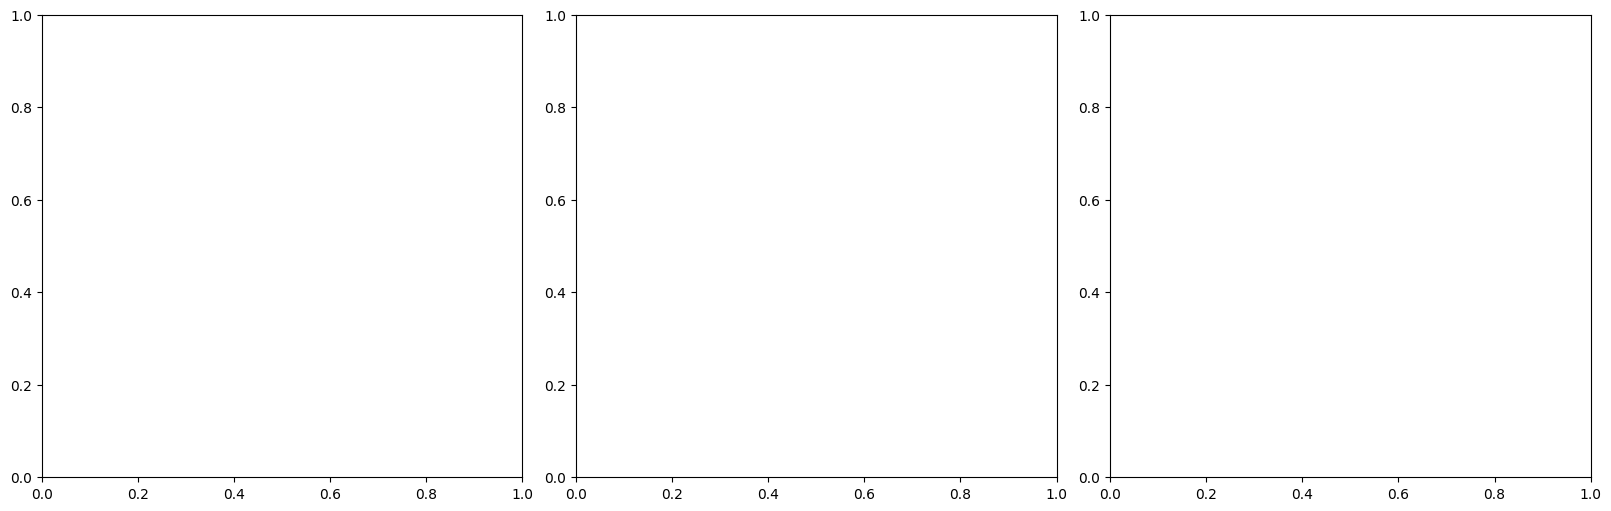

In [26]:
### examples
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (16, 5))

n = [0, 50, 200]
s = np.arange(92)
for i in range(3):

    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n[i]], pca_state, alpha1, gamma1, 2000)
    uqno_lower, uqno_upper = uqn1_lower[n1], uqn1_upper[n[i]]

    ax[i].set_ylim(-1.5, 1.5)
    ax[i].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
    ax[i].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
    ax[i].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
    ax[i].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
    ax[i].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
    ax[i].plot(uqno_lower, c = 'C2', lw = 0.5)
    ax[i].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
    ax[i].plot(lsc1_lower, c = 'C3', lw = 1.5)
    ax[i].plot(rtest[n[i]], c = 'black')
    
    ax[i].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)
    
    ax[i].set_title(f't = {n[i]}', fontsize = 18)
ax[-1].legend(ncol = 4, fontsize = 12)

plt.show()

In [81]:
# plt.imshow(vp[0])
# plt.colorbar()

In [82]:
# u = swe.random_initial_condition()

# fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (15, 4))
# ax[0].imshow(swe.isht(swe.timestep(u, 0))[0])
# ax[1].imshow(swe.isht(swe.timestep(u, 10))[0])
# ax[2].imshow(swe.isht(swe.timestep(u, 100))[0])

In [83]:
# plt.imshow(swe.isht(swe.timestep(u, 10))[0] - swe.isht(swe.timestep(u, 100))[0])
# plt.colorbar()

In [263]:
# z_score = 3.27
# oracle_sd = np.std(rtest, axis = 1)
oracle_rc = []
oracle_width = []
for i in trange(0, ytest.shape[0]):
    
    # Oracle    
    oracle_lower = jnp.min(rtest[i]) * jnp.ones((92,)) - 1e-7
    oracle_upper = jnp.max(rtest[i]) * jnp.ones((92,)) + 1e-7
    oracle_rc.append(risk(oracle_lower, oracle_upper, rtest[i]))
    oracle_width.append(jnp.mean(oracle_upper - oracle_lower))

oracle_rc = np.array(oracle_rc)
oracle_width = np.array(oracle_width)

  0%|          | 0/500 [00:00<?, ?it/s]

In [265]:
noise_sd = np.std(rtest, axis = 1)

risk_control = np.mean(oracle_rc >= 0.99), \
               np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(oracle_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, oracle_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [266]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 0.613 & 0.984 \\
0.852 & -0.568 & 1.285 & 0.000 \\
0.888 & -0.505 & 1.422 & 0.000 \\
0.968 & -0.297 & 1.602 & 0.182 \\
0.924 & -0.013 & 0.912 & 0.928 \\
0.896 & -0.035 & 0.876 & 0.926 \\
